<a href="https://www.kaggle.com/code/samithsachidanandan/predicting-loan-payback-baseline?scriptVersionId=272974633" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Import Libraries 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import scatter_matrix
from sklearn import set_config
set_config(display='diagram')


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform





### Loading the Data 

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')

### Basic Statistics

In [3]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
test.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


In [5]:
train.shape

(593994, 13)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [7]:
train.dtypes

id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back          float64
dtype: object

In [8]:
print("Target column statistics (loan_paid_back):")

train['loan_paid_back'].describe()

Target column statistics (loan_paid_back):


count    593994.000000
mean          0.798820
std           0.400883
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: loan_paid_back, dtype: float64

In [9]:
train.isnull().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [10]:
print("Duplicated Rows:",train.duplicated().sum())

Duplicated Rows: 0


In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,593994.0,296996.500000,171471.442235,0.000,148498.250,296996.500,445494.750,593993.000
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990
loan_paid_back,593994.0,0.798820,0.400883,0.000,1.000,1.000,1.000,1.000


### Exploratory Data Analysis

#### Numerical Features Distribution

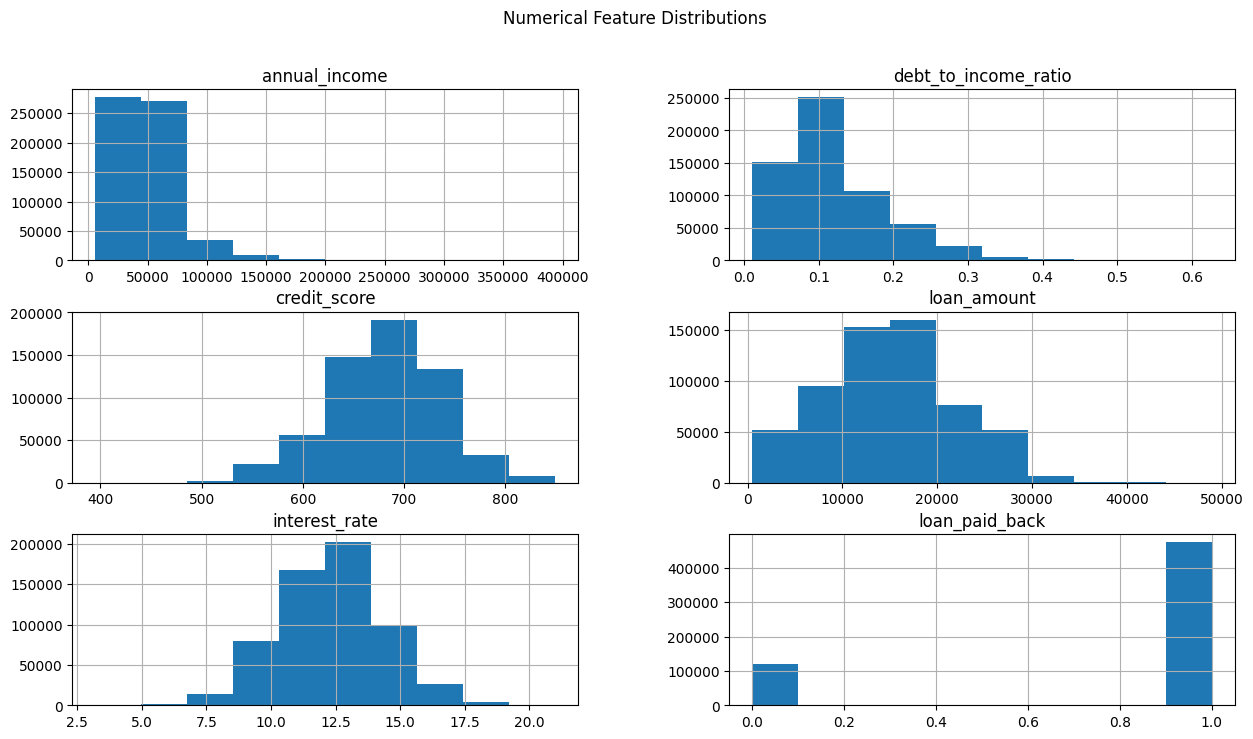

In [12]:
num_cols = train.select_dtypes(include=[np.number]).columns.drop('id')
train[num_cols].hist(figsize=(15, 8), bins=10)
plt.suptitle("Numerical Feature Distributions")
plt.show()

#### Correlation Matrix

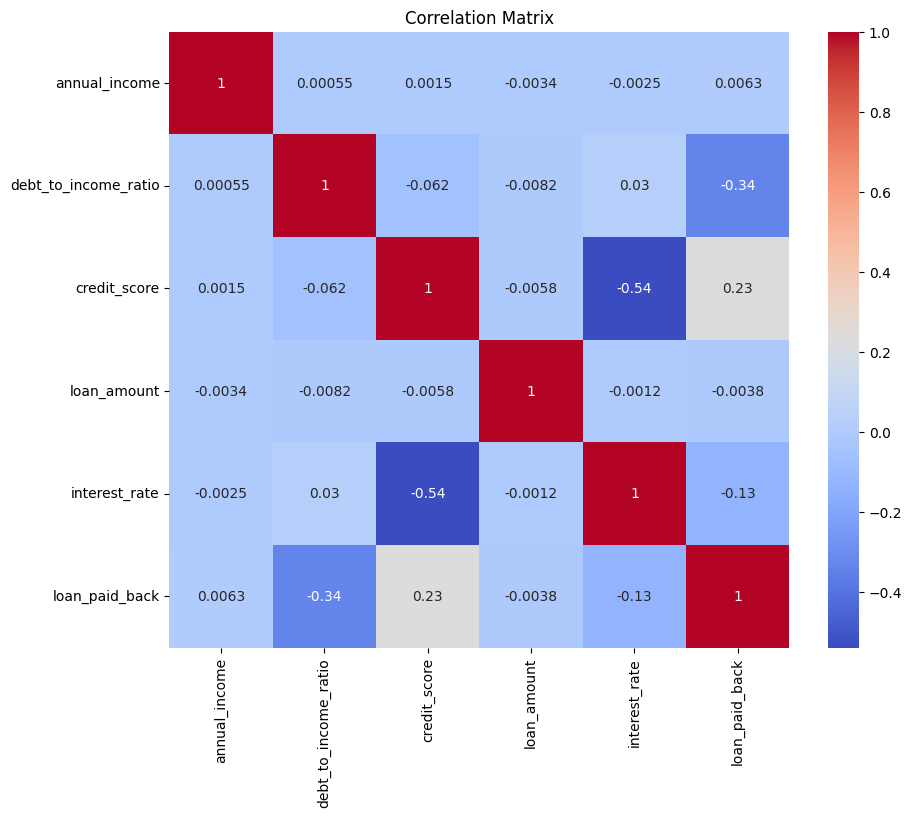

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#### Scatter Matrix 

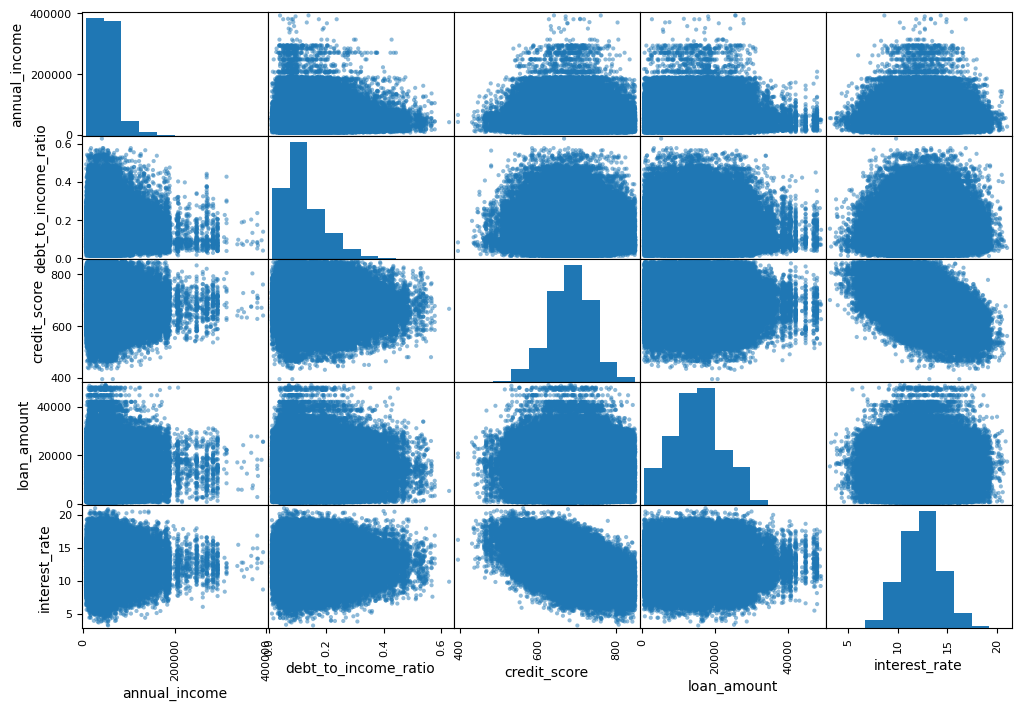

In [14]:

attributes = ["annual_income", "debt_to_income_ratio", "credit_score",
     "loan_amount","interest_rate"]
scatter_matrix(train[attributes], figsize=(12, 8))
plt.show()

#### Boxplots for Outlier Detection

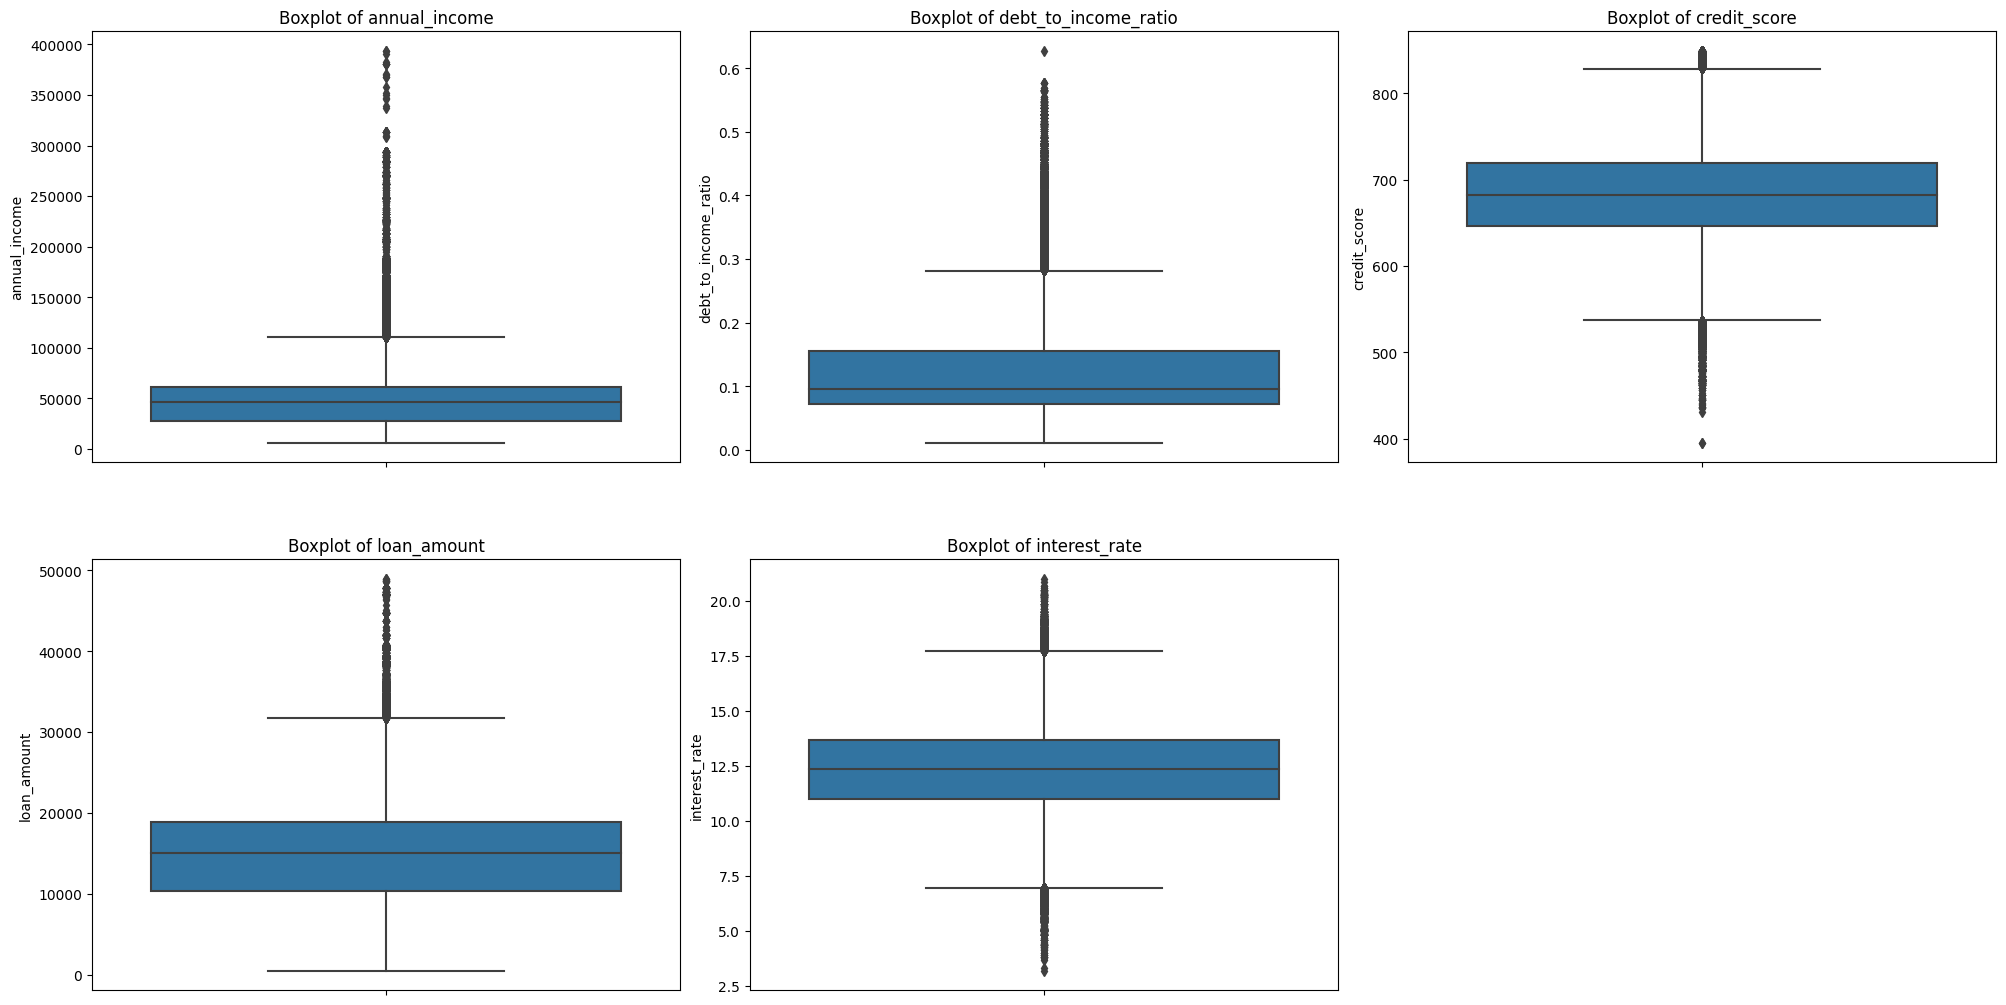

In [15]:
num_cols = num_cols.drop('loan_paid_back') 
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
ax = ax.flatten()

index = 0
for col in num_cols:
    sns.boxplot(y=col, data=train, ax=ax[index])
    ax[index].set_title(f"Boxplot of {col}")
    index += 1


for j in range(index, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

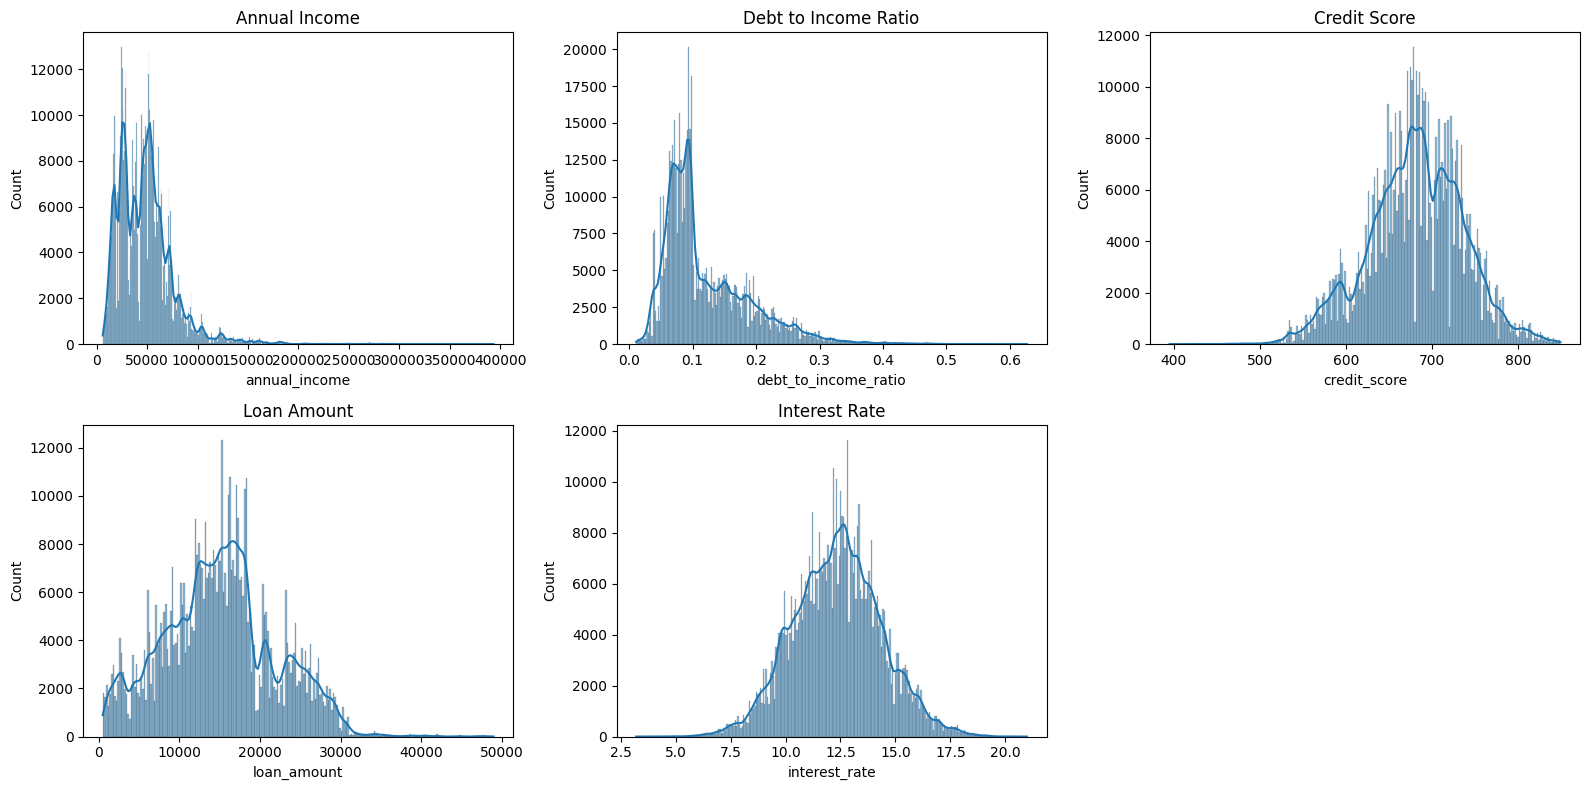

In [16]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
sns.histplot(train['annual_income'], kde=True)
plt.title('Annual Income')

plt.subplot(2, 3, 2)
sns.histplot(train['debt_to_income_ratio'], kde=True)
plt.title('Debt to Income Ratio')

plt.subplot(2, 3, 3)
sns.histplot(train['credit_score'], kde=True)
plt.title('Credit Score')

plt.subplot(2, 3, 4)
sns.histplot(train['loan_amount'], kde=True)
plt.title('Loan Amount')

plt.subplot(2, 3, 5)
sns.histplot(train['interest_rate'], kde=True)
plt.title('Interest Rate')

plt.tight_layout()
plt.show()


### Univariate Analysis of Target Variable

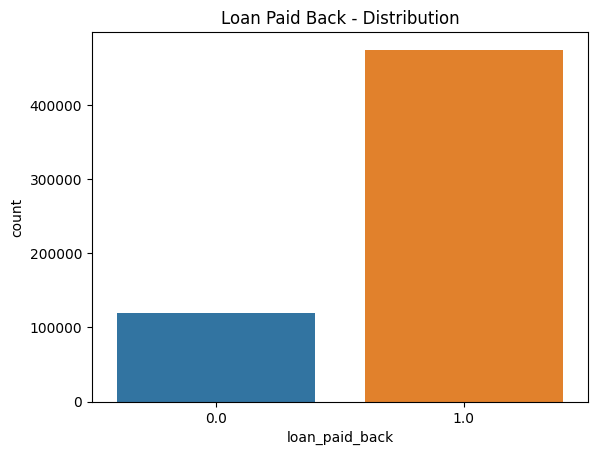

loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

In [17]:
sns.countplot(x=train["loan_paid_back"])
plt.title("Loan Paid Back - Distribution")
plt.show()

train["loan_paid_back"].value_counts(normalize=True)

### Bivariate Analysis

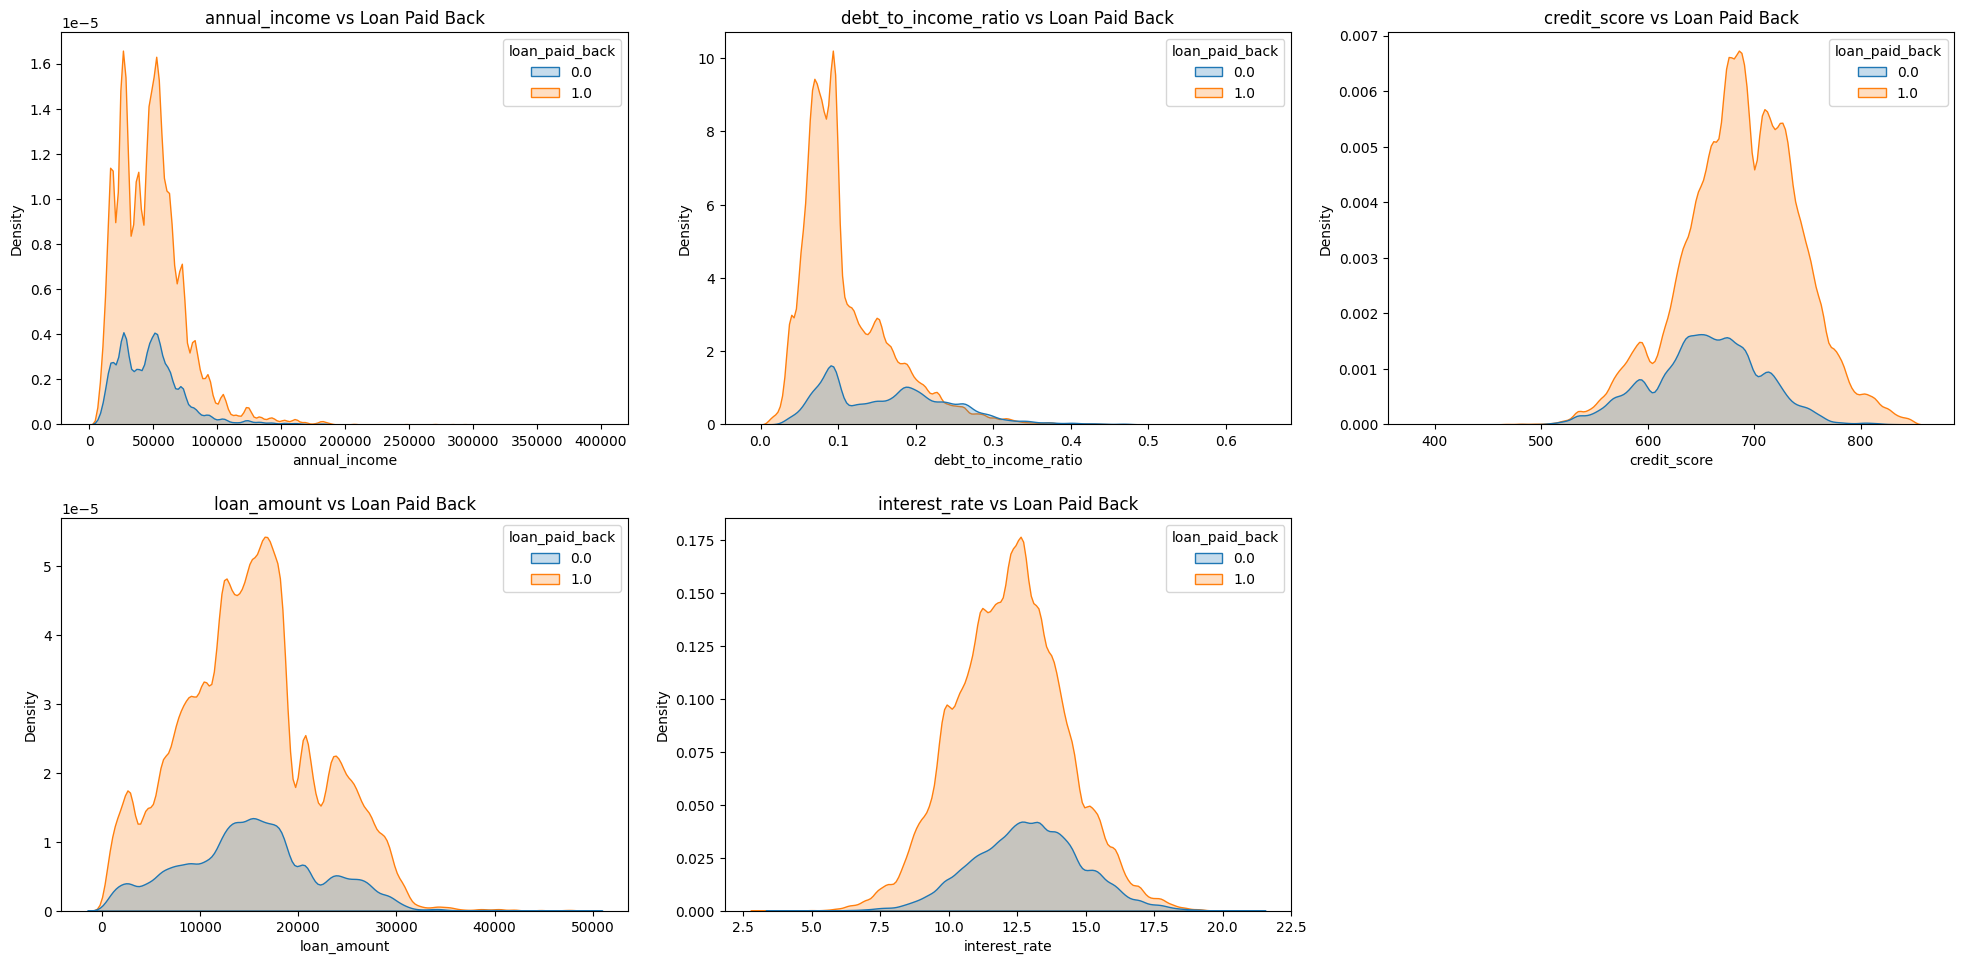

In [18]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(
        data=train,
        x=col,
        hue="loan_paid_back",
        fill=True,
        ax=ax[i]
    )
    ax[i].set_title(f"{col} vs Loan Paid Back")


for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(pad=2.0)
plt.show()

#### Categorical vs Target

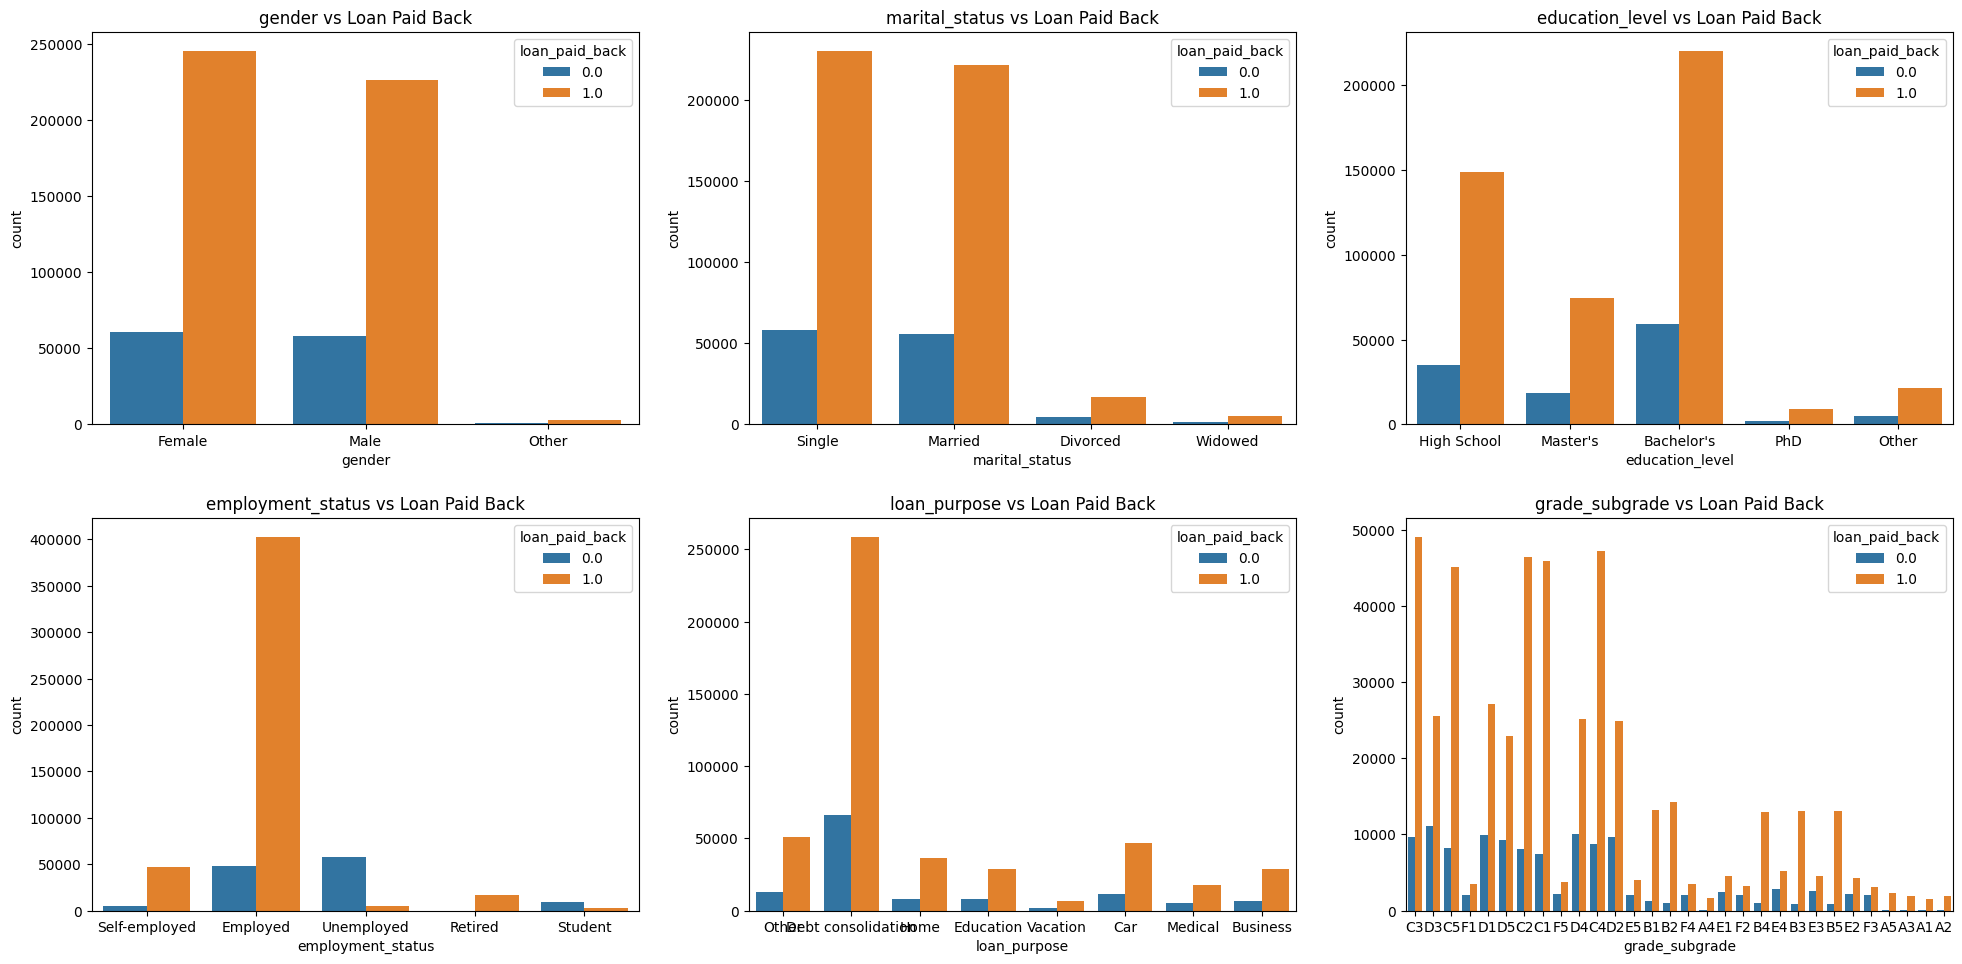

In [19]:
cat_cols = train.select_dtypes(include=['object']).columns
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
ax = ax.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(
        data=train,
        x=col,
        hue="loan_paid_back",
        fill=True,
        ax=ax[i]
    )
    ax[i].set_title(f"{col} vs Loan Paid Back")


for j in range(i+1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(pad=2.0)
plt.show()

#### Loan Amount vs Interest Rate

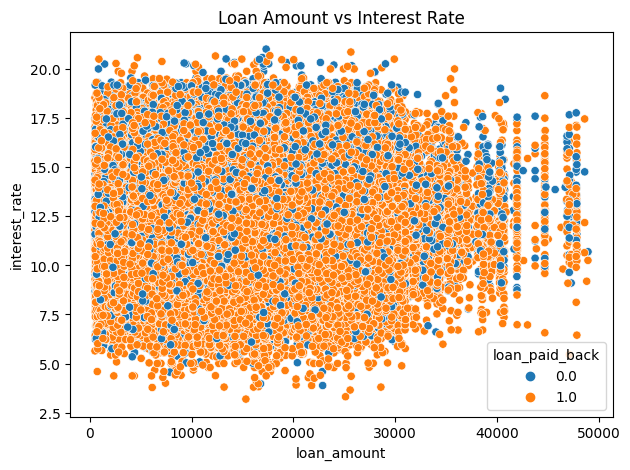

In [20]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=train, x="loan_amount", y="interest_rate", hue="loan_paid_back")
plt.title("Loan Amount vs Interest Rate")
plt.show()

#### Debt-to-Income Ratio Analysis

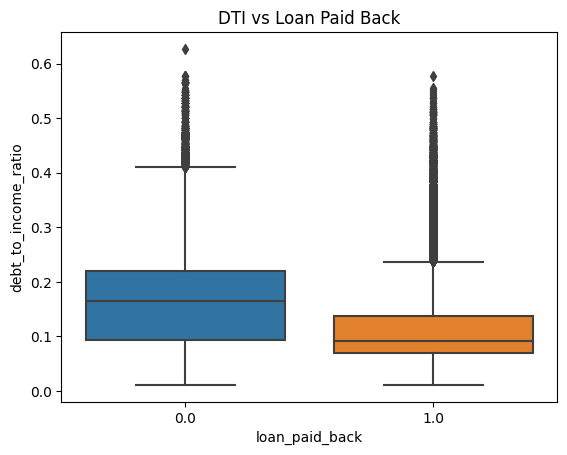

In [21]:
sns.boxplot(data=train, x="loan_paid_back", y="debt_to_income_ratio")
plt.title("DTI vs Loan Paid Back")
plt.show()

#### Education Level insights 

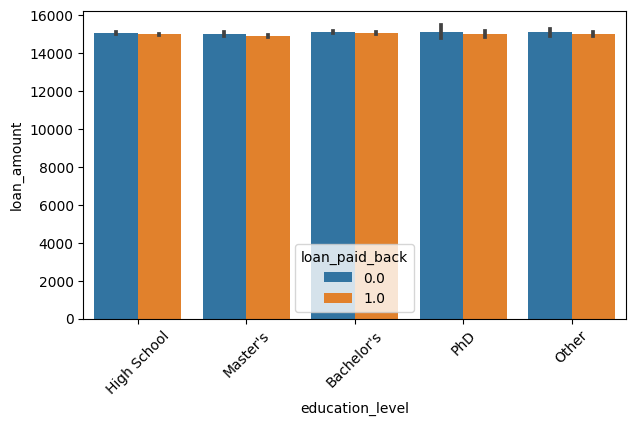

In [22]:
plt.figure(figsize=(7,4))
sns.barplot(data=train, x="education_level", y="loan_amount", hue="loan_paid_back")
plt.xticks(rotation=45)
plt.show()

#### Employment Status insights 

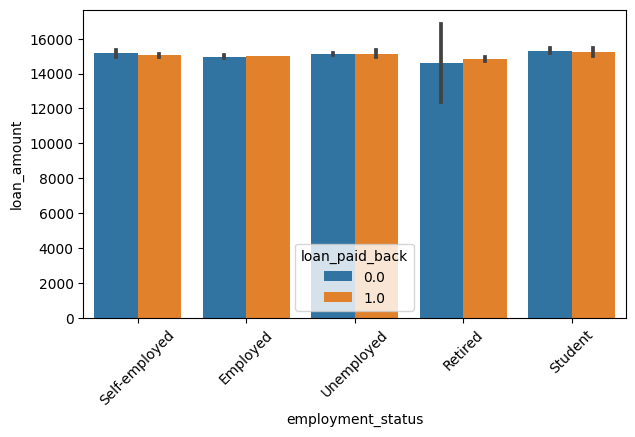

In [23]:
plt.figure(figsize=(7,4))
sns.barplot(data=train, x="employment_status", y="loan_amount", hue="loan_paid_back")
plt.xticks(rotation=45)
plt.show()

#### Grade vs Loan Outcome

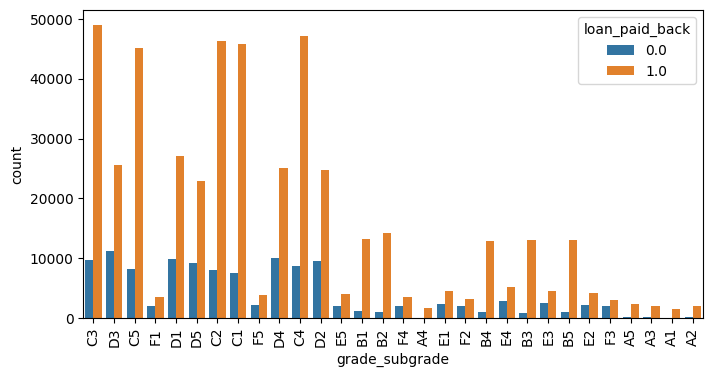

In [24]:
plt.figure(figsize=(8,4))
sns.countplot(data=train, x="grade_subgrade", hue="loan_paid_back")
plt.xticks(rotation=90)
plt.show()

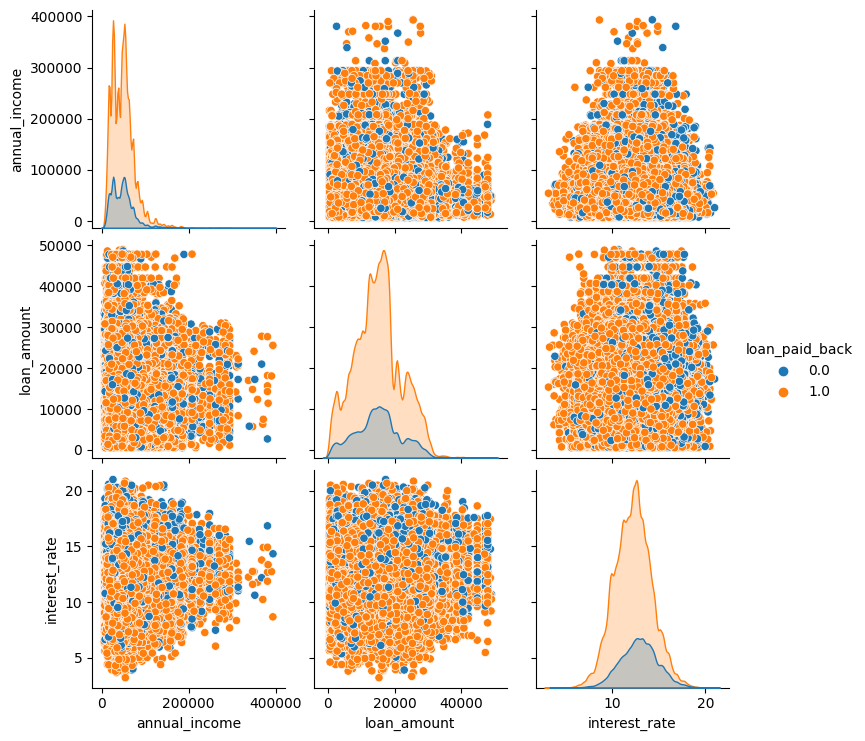

In [25]:
sns.pairplot(train, hue='loan_paid_back', vars = ['annual_income','loan_amount','interest_rate' ])
plt.show()

### Removing the outliers

#### Z-score Method

In [26]:
num_cols



Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')

In [27]:
upper_limit_credit_score = train['credit_score'].mean() + 3 *train['credit_score'].std()
lower_limit_credit_score = train['credit_score'].mean() - 3 *train['credit_score'].std()
upper_limit_interest_rate = train['interest_rate'].mean() + 3 *train['interest_rate'].std()
lower_limit_interest_rate = train['interest_rate'].mean() - 3 *train['interest_rate'].std()

In [28]:
train['credit_score'] = np.where(train['credit_score'] > upper_limit_credit_score,upper_limit_credit_score,np.where(train['credit_score']<lower_limit_credit_score, lower_limit_credit_score,train['credit_score']))

In [29]:
train['interest_rate'] = np.where(train['interest_rate'] > upper_limit_interest_rate,upper_limit_interest_rate,np.where(train['interest_rate']<lower_limit_interest_rate, lower_limit_interest_rate,train['interest_rate']))

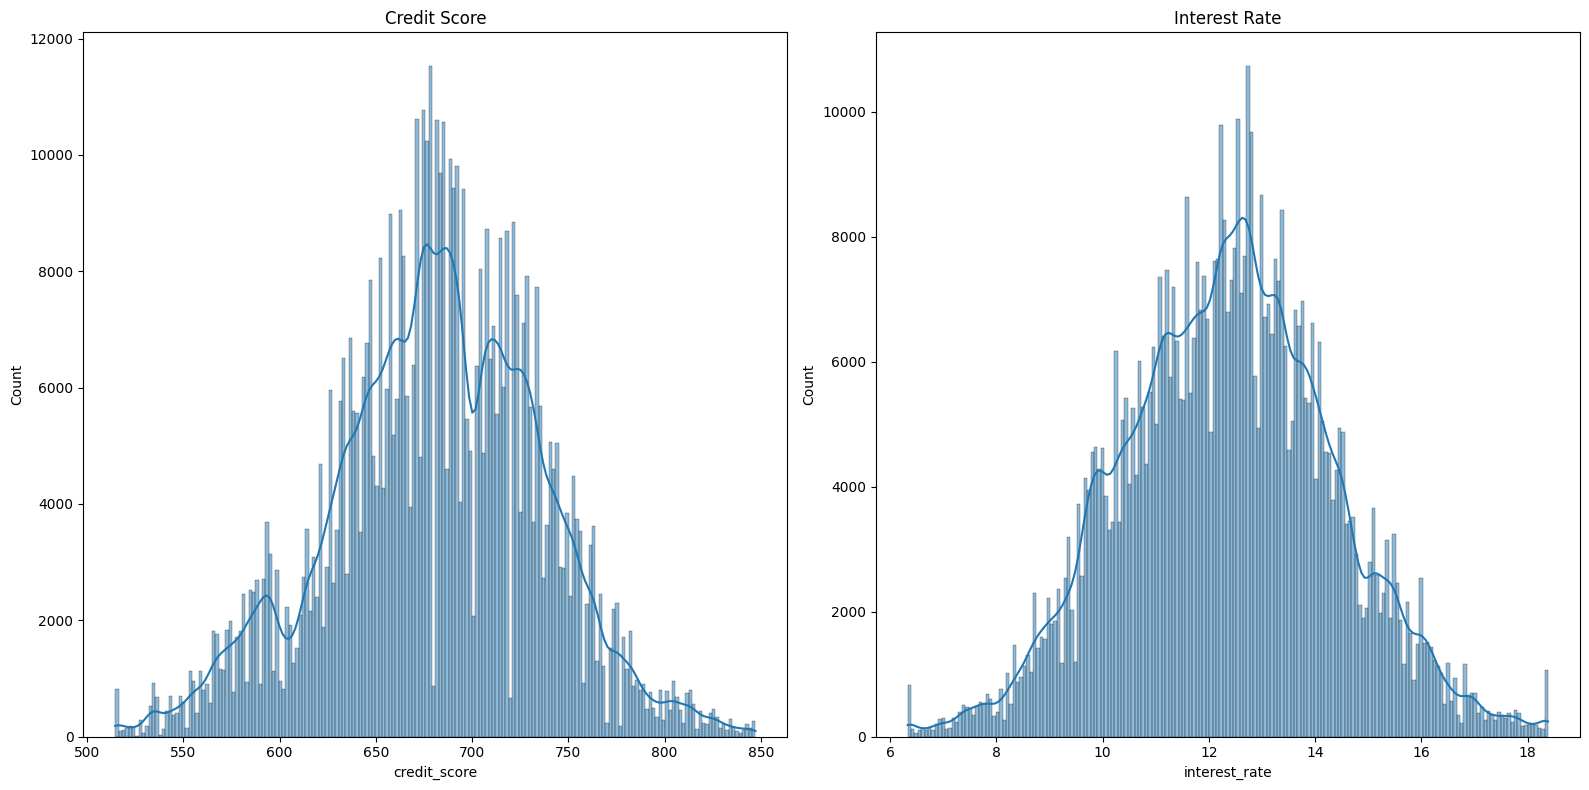

In [30]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.histplot(train['credit_score'], kde=True)
plt.title('Credit Score')

plt.subplot(1, 2, 2)
sns.histplot(train['interest_rate'], kde=True)
plt.title('Interest Rate')

plt.tight_layout()
plt.show()


#### IQR Method 

In [31]:
train['annual_income'].skew()

1.719508683164502

In [32]:
train['debt_to_income_ratio'].skew()

1.4066799385489641

In [33]:
train['loan_amount'].skew()

0.2073598200202166

In [34]:
features = [ 'annual_income','debt_to_income_ratio','loan_amount' ]



for feature in features:
    Q1 = train[feature].quantile(0.25)
    Q3 = train[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    
    train[feature] = np.where(train[feature] >upper, upper, np.where(train[feature]<lower,lower, train[feature]) )

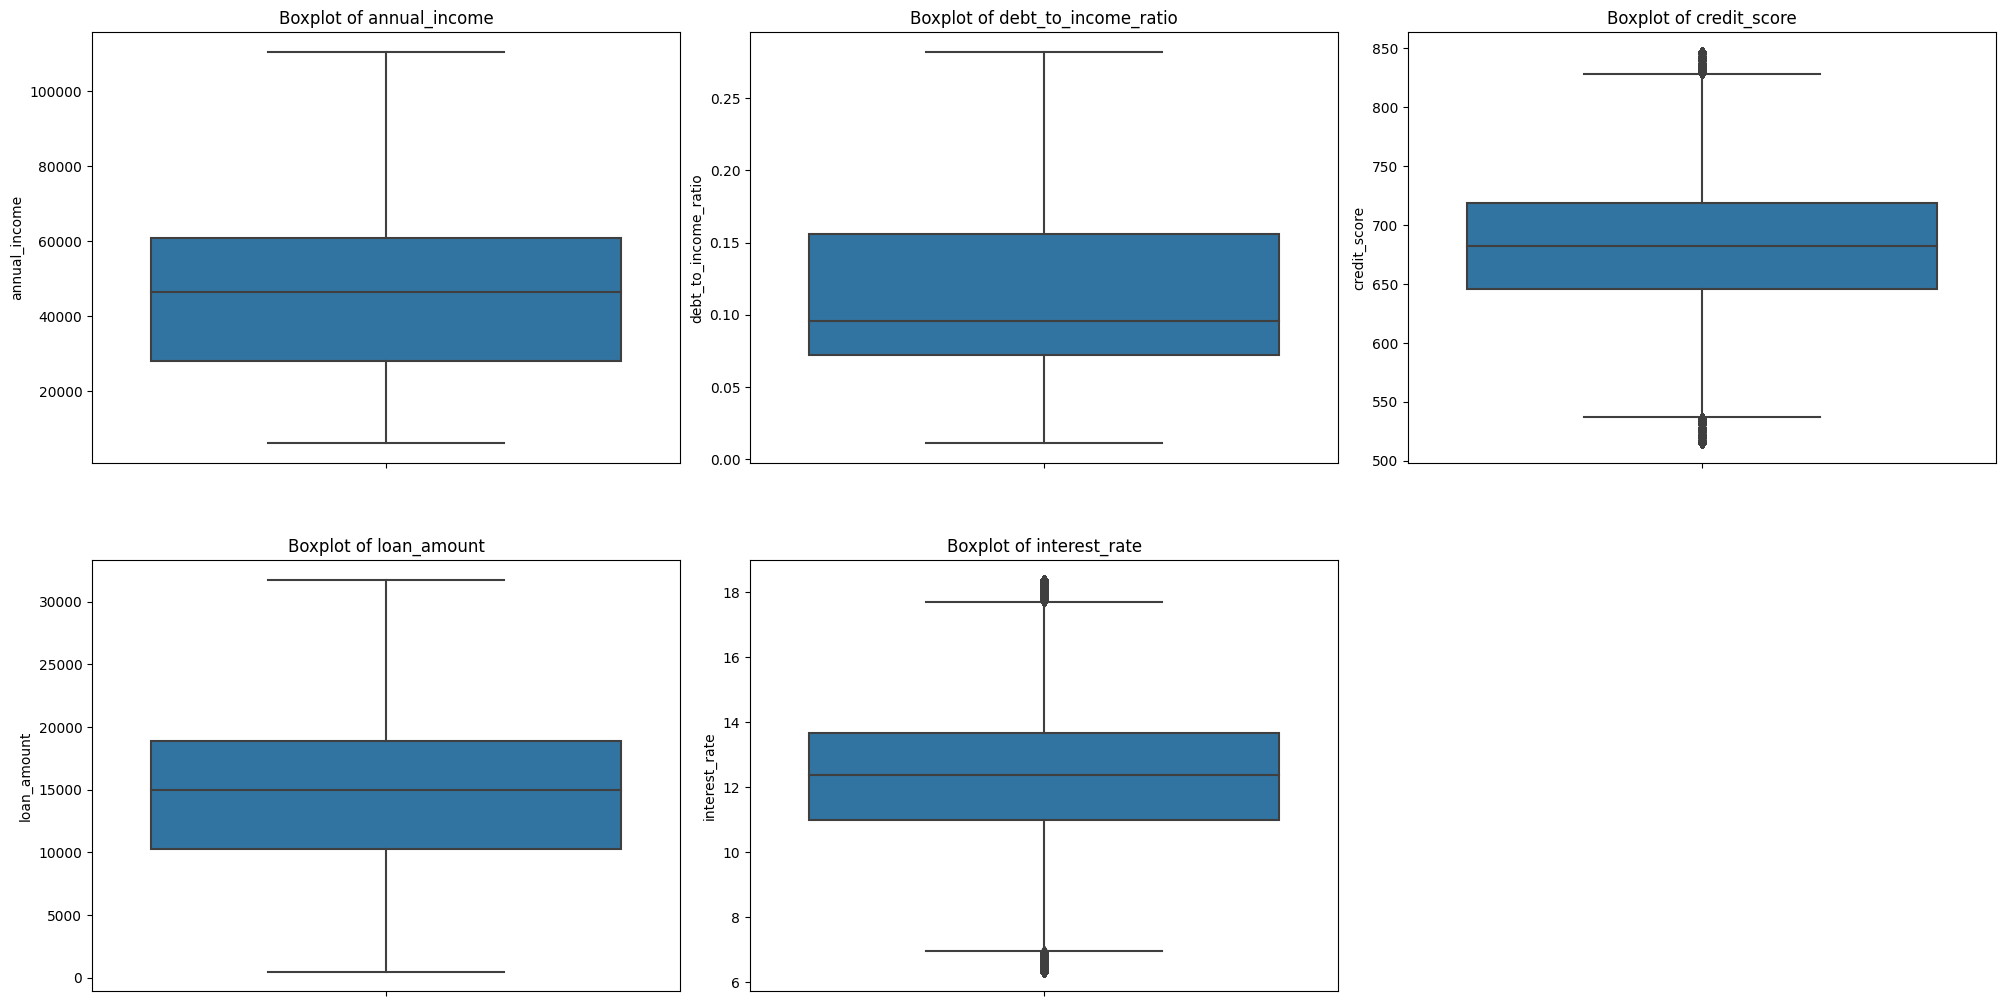

In [35]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
ax = ax.flatten()

index = 0
for col in num_cols:
    sns.boxplot(y=col, data=train, ax=ax[index])
    ax[index].set_title(f"Boxplot of {col}")
    index += 1


for j in range(index, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

### Feature Engineering 

In [36]:
cat_cols

Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')

In [37]:
def engineer_features(df):
    
    df = df.copy()
    
    df['monthly_income'] = df['annual_income'] / 12
    df['monthly_payment'] = (df['loan_amount'] * df['interest_rate'] / 100) / 12
    df['payment_to_income_ratio'] = df['monthly_payment'] / df['monthly_income']
    
    
    df['total_debt'] = df['loan_amount'] * df['debt_to_income_ratio']
    df['monthly_debt'] = df['total_debt'] / 12
    df['remaining_income'] = df['monthly_income'] - df['monthly_debt']
    
    
    df['credit_efficiency'] = df['credit_score'] / df['debt_to_income_ratio']
    df['loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']
    
    
    df['income_bracket'] = pd.cut(df['annual_income'], 
                                   bins=[0, 25000, 50000, 75000, 100000, np.inf],
                                   labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    
    df['credit_category'] = pd.cut(df['credit_score'],
                                    bins=[0, 580, 670, 740, 800, np.inf],
                                    labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])
    
    
    df['loan_size'] = pd.cut(df['loan_amount'],
                              bins=[0, 5000, 10000, 20000, np.inf],
                              labels=['Small', 'Medium', 'Large', 'Very Large'])
    
    
    df['rate_category'] = pd.cut(df['interest_rate'],
                                  bins=[0, 10, 15, 20, np.inf],
                                  labels=['Low', 'Medium', 'High', 'Very High'])
    
    
    df['risk_score'] = (df['debt_to_income_ratio'] * df['interest_rate']) / df['credit_score']
    df['income_credit_interaction'] = df['annual_income'] * df['credit_score']
    df['debt_credit_interaction'] = df['debt_to_income_ratio'] * df['credit_score']
    

    df['credit_score_squared'] = df['credit_score'] ** 2
    df['debt_ratio_squared'] = df['debt_to_income_ratio'] ** 2
    df['income_log'] = np.log1p(df['annual_income'])
    df['loan_amount_log'] = np.log1p(df['loan_amount'])
    
   
    df['gender_marital'] = df['gender'] + '_' + df['marital_status']
    df['education_employment'] = df['education_level'] + '_' + df['employment_status']
    
   
    df['high_risk_flag'] = ((df['debt_to_income_ratio'] > 0.4) | 
                            (df['credit_score'] < 650) | 
                            (df['interest_rate'] > 15)).astype(int)
    
    df['excellent_credit_flag'] = (df['credit_score'] >= 750).astype(int)
    df['high_income_flag'] = (df['annual_income'] >= 50000).astype(int)
    df['has_advanced_degree'] = (df['education_level'] == "Master's").astype(int)
    
 
    gender_income_mean = df.groupby('gender')['annual_income'].transform('mean')
    df['income_vs_gender_avg'] = df['annual_income'] / gender_income_mean
    

    edu_income_mean = df.groupby('education_level')['annual_income'].transform('mean')
    df['income_vs_edu_avg'] = df['annual_income'] / edu_income_mean
    
  
        
    return df


In [38]:
train_df = engineer_features(train)



In [39]:
test_df = engineer_features(test)

In [40]:
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_cols = [col for col in numeric_cols if col != 'loan_paid_back']


categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()



print("*"*180)
print("Numeric:", numeric_cols)

print("*"*180)

print("Categorical:", categorical_cols)
print("*"*180)



************************************************************************************************************************************************************************************
Numeric: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'monthly_income', 'monthly_payment', 'payment_to_income_ratio', 'total_debt', 'monthly_debt', 'remaining_income', 'credit_efficiency', 'loan_to_income_ratio', 'risk_score', 'income_credit_interaction', 'debt_credit_interaction', 'credit_score_squared', 'debt_ratio_squared', 'income_log', 'loan_amount_log', 'high_risk_flag', 'excellent_credit_flag', 'high_income_flag', 'has_advanced_degree', 'income_vs_gender_avg', 'income_vs_edu_avg']
************************************************************************************************************************************************************************************
Categorical: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpos

### Preprocesing and Scaling Pipeline

In [41]:
train_df['education_employment'].value_counts()

education_employment
Bachelor's_Employed          210779
High School_Employed         140074
Master's_Employed             70970
Bachelor's_Unemployed         31178
Bachelor's_Self-employed      24441
Other_Employed                20361
High School_Unemployed        18148
High School_Self-employed     16238
Master's_Unemployed            9513
PhD_Employed                   8461
Master's_Self-employed         8410
Bachelor's_Retired             7461
Bachelor's_Student             5747
High School_Retired            5494
High School_Student            3638
Other_Unemployed               2678
Other_Self-employed            2400
Master's_Retired               2319
Master's_Student               1885
PhD_Self-employed               991
PhD_Unemployed                  968
Other_Retired                   757
Other_Student                   481
PhD_Retired                     422
PhD_Student                     180
Name: count, dtype: int64

In [42]:
y_train = train_df['loan_paid_back']
X_train = train_df.drop('loan_paid_back', axis=1)

X_test = test_df.copy() 

In [43]:
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ('scale', MinMaxScaler(), numeric_cols)
])

In [44]:
tune_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', xgb.XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

In [45]:
# param_dist = {
#     'model__n_estimators': randint(300, 800),
#     'model__max_depth': randint(3, 10),
#     'model__learning_rate': uniform(0.01, 0.2),
#     'model__subsample': uniform(0.6, 0.4),
#     'model__colsample_bytree': uniform(0.6, 0.4),
#     'model__min_child_weight': randint(1, 10),
#     'model__gamma': uniform(0, 5)
# }

In [46]:
import torch

param_dist = {
    "objective"             : "binary:logistic",
    "eval_metric"           : "auc",
    "device"                : "cuda:0", 
    "learning_rate"         : 0.075,        
    "n_estimators"          : 630,
    "max_depth"             : 7,
    "subsample"             : 0.88,
    "colsample_bytree"      : 0.66,
    "reg_lambda"            : 0.75,
    "reg_alpha"             : 0.001,
    "verbosity"             : 0,
    "random_state"          : 42,
    "enable_categorical"    : False,
    
    "min_child_weight"      : 5,
    "gamma"                 : 1.0
}


### Model Training 

In [47]:
 # models = [
 #     ('XGB', xgb.XGBClassifier()),
 #     ('RF', RandomForestClassifier()),
 #     ('LR', LogisticRegression()),
 #     ]

models = [
    ('XGB', xgb.XGBClassifier(**param_dist))
]


In [48]:



def run_oof_cv_models(models, preprocessor, X, y, n_splits=5):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {}
    oof_preds = {}
    model_folds = {}

    for name, model in models:
        print(f"\n{'-'*60}")
        print(f"Running OOF CV for Model: {name}")
        print(f"{'-'*60}")

        oof = np.zeros(len(X))
        fold_models = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"\nFold {fold+1}/{n_splits}")

            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

            # Pipeline with preprocessing
            pipe = Pipeline([
                ('prep', preprocessor),
                ('model', model)
            ])

            pipe.fit(X_train_fold, y_train_fold)
            fold_models.append(pipe)

            
            val_preds = pipe.predict_proba(X_val_fold)[:, 1]
            oof[val_idx] = val_preds

            fold_auc = roc_auc_score(y_val_fold, val_preds)
            print(f"Fold {fold+1} ROC AUC={fold_auc:.6f}")

        oof_preds[name] = oof
        model_folds[name] = fold_models

        overall_auc = roc_auc_score(y, oof)
        results[name] = overall_auc
        print(f"\n{name} OOF CV ROC AUC={overall_auc:.6f}")

    return results, oof_preds, model_folds

In [49]:
results, oof_predictions, trained_models = run_oof_cv_models(
    models=models,
    preprocessor=preprocessor,
    X=X_train,
    y=y_train,
    n_splits=5
)


------------------------------------------------------------
Running OOF CV for Model: XGB
------------------------------------------------------------

Fold 1/5
Fold 1 ROC AUC=0.920956

Fold 2/5
Fold 2 ROC AUC=0.921175

Fold 3/5
Fold 3 ROC AUC=0.920139

Fold 4/5
Fold 4 ROC AUC=0.917986

Fold 5/5
Fold 5 ROC AUC=0.920002

XGB OOF CV ROC AUC=0.920047


In [50]:
print("\nTraining final XGBoost model on full dataset...")

final_xgb = Pipeline([
    ('prep', preprocessor),
    ('model', xgb.XGBClassifier(**param_dist))
])

final_xgb.fit(X_train, y_train)


test_preds = final_xgb.predict(X_test)

print("\nFinal XGBoost model trained successfully!") 
print(f"Number of original features: {len(features)}") 
unique, counts = np.unique(test_preds, return_counts=True) 
print("Prediction distribution:", dict(zip(unique, counts)))

os.makedirs("saved_models", exist_ok=True)

joblib.dump(final_xgb, "saved_models/final_xgb_tuned.joblib")

print("Final tuned model saved!")


Training final XGBoost model on full dataset...

Final XGBoost model trained successfully!
Number of original features: 3
Prediction distribution: {0: 33770, 1: 220799}
Final tuned model saved!


In [51]:


# os.makedirs("saved_models", exist_ok=True)

# final_models = {}        
# test_predictions = {}    

# print("\nTraining ALL final models on full dataset...\n")

# for name, model in models:
#     print(f"{'='*60}")
#     print(f"Training model: {name}")
#     print(f"{'='*60}")
    
    
#     pipe = Pipeline([
#         ('prep', preprocessor),
#         ('model', model)
#     ])
    
  
#     pipe.fit(X_train, y_train)
    
   
#     filepath = f"saved_models/{name}_final_model.joblib"
#     joblib.dump(pipe, filepath)
#     print(f"Saved model: {filepath}")
    
    
#     preds = pipe.predict(X_test)
#     test_predictions[name] = preds
    
  
#     unique, counts = np.unique(preds, return_counts=True)
#     print("Prediction distribution:", dict(zip(unique, counts)))
    

# print("\n All models trained and saved successfully!")



In [52]:
print("Submission shape:", submission.shape)
print("Test predictions shape:", len(test_preds))

Submission shape: (254569, 2)
Test predictions shape: 254569


In [53]:
submission = submission.copy()
submission['loan_paid_back'] = test_preds

submission.to_csv('submission.csv', index=False)
print("\n Submission saved to 'submission.csv'")


 Submission saved to 'submission.csv'
